# Big data project
## Project organization
We organized our project in the following way:
1. Choose a region thanks to global indicators in France
2. Choose a department in this region to refine your search
3. Choose a city to see all available house rentals

# Global indicators on regions in France
- Number of inhabitants in each region
- Population trends / Population growth rate
- A selection of the most populated cities
- Average rental price per m²
- ...

In [81]:
# Usefull imports
import pandas as pd
import xml.etree.cElementTree as et
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import widgets, interact

%matplotlib inline

In [68]:
# All functions used
def select_region(Région):
    selected_region.value = str(Région)

# Replace accents
def without_accents(col):
    col = col.str.replace("á", "a")
    col = col.str.replace("à", "a")
    col = col.str.replace("â", "a")
    col = col.str.replace("ä", "a")
    col = col.str.replace("ã", "a")
    col = col.str.replace("å", "a")
    col = col.str.replace("ç", "c")
    col = col.str.replace("é", "e")
    col = col.str.replace("è", "e")
    col = col.str.replace("ê", "e")
    col = col.str.replace("ë", "e")
    col = col.str.replace("í", "i")
    col = col.str.replace("ì", "i")
    col = col.str.replace("î", "i")
    col = col.str.replace("ï", "i")
    col = col.str.replace("ñ", "n")
    col = col.str.replace("ó", "o")
    col = col.str.replace("ò", "o")
    col = col.str.replace("ô", "o")
    col = col.str.replace("ö", "o")
    col = col.str.replace("õ", "o")
    col = col.str.replace("ú", "u")
    col = col.str.replace("ù", "u")
    col = col.str.replace("û", "u")
    col = col.str.replace("ü", "u")
    col = col.str.replace("ý", "y")
    col = col.str.replace("ÿ", "y")
    col = col.str.replace("æ", "ae")
    col = col.str.replace("œ", "oe")
    return col

# Return the value of a node during the reading of XML
def getValue(node):
    return node.text if node is not None else None

In [69]:
# Read CSV
electricity = pd.read_csv('consommation-electrique-par-secteur-dactivite-commune.csv', sep=";", encoding='utf-8')
# Drop useless columns
electricity.drop(["Nom EPCI", "Code EPCI", "Type EPCI", "Geo Shape", "Geo Point 2D"], axis=1, inplace=True)

# City standardization ("-" -> " " / uppercase -> lowercase / replace accents) to compare with rentals
electricity['NC'] = electricity['Nom commune']
electricity['NC'] = electricity['NC'].apply(lambda x: x.lower())
electricity['NC'] = without_accents(electricity['NC'])
electricity['NC'] = electricity['NC'].str.replace("-", " ")

electricity['ND'] = electricity['Nom département']
electricity['ND'] = electricity['ND'].apply(lambda x: x.lower())
electricity['ND'] = without_accents(electricity['ND'])
electricity['ND'] = electricity['ND'].str.replace("-", " ")

# Array of regions
regions = electricity['Nom région'].unique()
regions = sorted(regions)

# Array of departments
departments = electricity['Nom département'].unique()
departments = sorted(departments)

In [70]:
# Read XML
xml = et.parse('data.xml')

# Create a dataframe
rentals = pd.DataFrame(columns=['title', 'Prix'])

# Read data from XML file
for node in xml.getroot():
    title = node.find('title')
    price = node.find('creator')
    if title is not None and price is not None:
        rentals = rentals.append(pd.Series([getValue(title), getValue(price)], index=['title', 'Prix']), ignore_index=True)

# Split title into columns
rentals['title'] = rentals['title'].str.replace("Noorea > France > ", "")
rentals['Nom département'] = rentals['title'].str.split('>').str[1]
rentals['Nom commune'] = rentals['title'].str.split('>').str[2]
rentals['Surface'] = rentals['title'].str.split('>').str[4]
rentals['Surface'] = rentals['Surface'].str.replace(" m2", "")
rentals['Surface'] = rentals['Surface'].str.replace(" ", "")
rentals['title'] = rentals['title'].str.replace("Noorea > France > ", "")
rentals = rentals.drop('title', 1)
rentals['Prix'] = rentals['Prix'].str.replace(" €", "")
rentals['Prix'] = rentals['Prix'].str.replace(" ", "")

# Remove useless whitespaces
for index, row in rentals.iterrows():
    rentals.loc[index, 'Nom département'] = rentals.loc[index, 'Nom département'][:-1]
    rentals.loc[index, 'Nom département'] = rentals.loc[index, 'Nom département'][1:]
    rentals.loc[index, 'Nom commune'] = rentals.loc[index, 'Nom commune'][:-1]
    rentals.loc[index, 'Nom commune'] = rentals.loc[index, 'Nom commune'][1:]

# City standardization ("-" -> " " / uppercase -> lowercase / replace accents)
rentals['NC'] = rentals['Nom commune']
rentals['NC'] = rentals['NC'].apply(lambda x: x.lower())
rentals['NC'] = without_accents(rentals['NC'])
rentals['NC'] = rentals['NC'].str.replace("-", " ")

rentals['ND'] = rentals['Nom département']
rentals['ND'] = rentals['ND'].apply(lambda x: x.lower())
rentals['ND'] = without_accents(rentals['ND'])
rentals['ND'] = rentals['ND'].str.replace("-", " ")

rentals = rentals.sort_values(by=['NC', 'ND'])
electricity = electricity.sort_values(by=['NC', 'ND'])

# Electricity without years
tmp = electricity.drop_duplicates(['Nom commune', 'Nom département', 'Nom région'])
localities = tmp[['Nom commune', 'Nom département', 'Nom région', 'Nombre d\'habitants', 'NC', 'ND']]

# Association of the region with the department
for index, row in rentals.iterrows():
    tmp = localities.loc[localities['ND'] == rentals.loc[index, 'ND']]
    if not tmp.empty:
        rentals.loc[index, 'Nom région'] = tmp['Nom région'].iloc[0]

# Columns order
rentals = rentals[['Nom commune', 'Nom département', 'Nom région', 'Surface', 'Prix', 'NC', 'ND']]
rentals['Prix'] = pd.to_numeric(rentals['Prix'])
rentals['Surface'] = pd.to_numeric(rentals['Surface'])

## Global statistics
### Number of inhabitants in each region

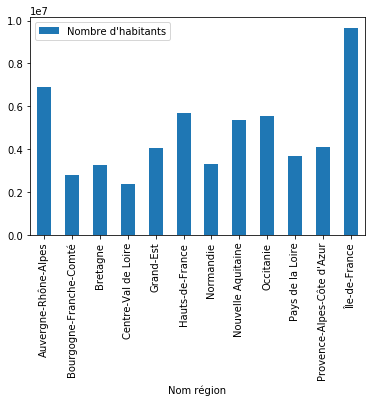

In [71]:
# Total population
total_population = localities['Nombre d\'habitants'].sum(axis=0)

# Population per regions
population_by_region = pd.DataFrame(columns=['Nom région', 'Nombre d\'habitants'])
population_by_region['Nom région'] = regions

for index, row in population_by_region.iterrows():
    population_by_region.loc[index, 'Nombre d\'habitants'] = localities.loc[localities['Nom région'] == population_by_region.loc[index, 'Nom région'], 'Nombre d\'habitants'].sum(axis=0)
population_by_region = population_by_region.set_index('Nom région')

#ax1 = plt.subplot(121, aspect='equal')
#population_by_region.plot(kind='pie', y='Nombre d\'habitants', ax=ax1, figsize=(15,15), labels=population_by_region.index, legend=False, fontsize=8, autopct='%1.0f%%', pctdistance=0.8, labeldistance=1.2)
population_by_region.plot(kind='bar')

### Population trends / Population growth rate

Figures aren't very accurate, that's why curves are linear


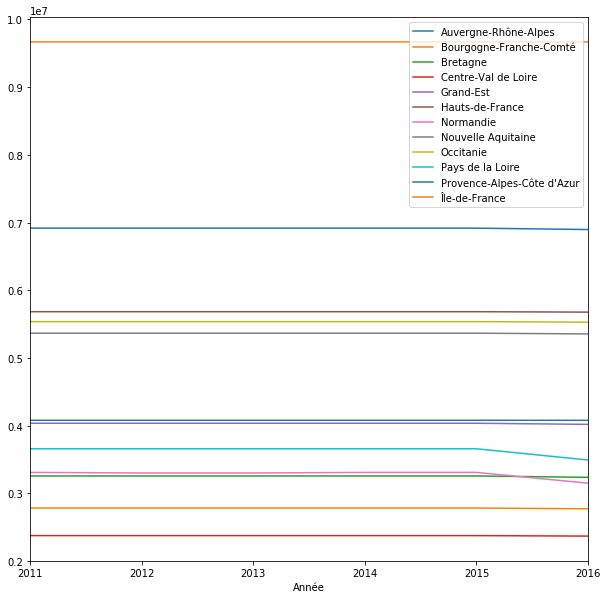

In [169]:
# Evolution of population
trends_population_by_region = pd.DataFrame(columns=[regions])
trends_population_by_region['Année'] = []
trends_population_by_region['Année'] = trends_population_by_region['Année'].astype(int)
trends_population_by_region = trends_population_by_region.set_index('Année')

for index, row in trends_population_by_region.iteritems():
    trends_population_by_region.loc[2011, index] = electricity.loc[(electricity['Nom région'] == index) & (electricity['Année'] == 2011), 'Nombre d\'habitants'].sum(axis=0)
    trends_population_by_region.loc[2012, index] = electricity.loc[(electricity['Nom région'] == index) & (electricity['Année'] == 2012), 'Nombre d\'habitants'].sum(axis=0)
    trends_population_by_region.loc[2013, index] = electricity.loc[(electricity['Nom région'] == index) & (electricity['Année'] == 2013), 'Nombre d\'habitants'].sum(axis=0)
    trends_population_by_region.loc[2014, index] = electricity.loc[(electricity['Nom région'] == index) & (electricity['Année'] == 2014), 'Nombre d\'habitants'].sum(axis=0)
    trends_population_by_region.loc[2015, index] = electricity.loc[(electricity['Nom région'] == index) & (electricity['Année'] == 2015), 'Nombre d\'habitants'].sum(axis=0)
    trends_population_by_region.loc[2016, index] = electricity.loc[(electricity['Nom région'] == index) & (electricity['Année'] == 2016), 'Nombre d\'habitants'].sum(axis=0)
    #trends_population_by_region.loc[index, 'Taux d\'accroissement'] = ((trends_population_by_region.loc[index, '2016'] - trends_population_by_region.loc[index, '2011']) / trends_population_by_region.loc[index, '2011']) * 100
print("Figures aren't very accurate, that's why curves are linear")
trends_population_by_region.plot(figsize=(10,10)) 

### A selection of the most populated cities

In [168]:
major_cities = pd.DataFrame(columns=['Nom région', 'Nom commune'])
major_cities['Nom région'] = regions
for index, row in major_cities.iterrows():
    major_cities.loc[index, 'Nom commune'] = localities.loc[(localities['Nom région'] == major_cities.loc[index, 'Nom région']), 'Nombre d\'habitants'].max(axis=0)
    major_cities.loc[index, 'Nom commune'] = (localities['Nom commune'][localities['Nombre d\'habitants'] == major_cities.loc[index, 'Nom commune']]).iloc[0]
print("Fluctuations may occur due to the data quality of the source file")
major_cities

Fluctuations may occur due to the data quality of the source file


,Nom région,Nom commune
0,Auvergne-Rhône-Alpes,Saint-Étienne
1,Bourgogne-Franche-Comté,Dijon
2,Bretagne,Rennes
3,Centre-Val de Loire,Tours
4,Grand-Est,Reims
5,Hauts-de-France,Lille
6,Normandie,Le Havre
7,Nouvelle Aquitaine,Bordeaux
8,Occitanie,Toulouse
9,Pays de la Loire,Nantes


### Average rental price per m²

In [66]:
average_rental_prices_regions = pd.DataFrame(columns=['Nom région', 'Average rental price per m²'])
average_rental_prices_regions['Nom région'] = regions
tmp = 0
for index, row in average_rental_prices_regions.iterrows():
    tmp += (rentals.loc[rentals['Nom région'] == average_rental_prices_regions.loc[index, 'Nom région'], 'Prix']) / (rentals.loc[rentals['Nom région'] == average_rental_prices_regions.loc[index, 'Nom région'], 'Surface'])
    average_rental_prices_regions.loc[index, 'Average rental price per m²'] = 0
    #print(tmp)
rentals

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

### Select a region to continue

In [43]:
# Create text widget for output
selected_region = widgets.Text()

interact(select_region, Région=regions)

# Display output variable in text box
selected_region

A Jupyter Widget

A Jupyter Widget

# Indicators in the selected region
- Statistics about each department:
    - Number of inhabitants
    - Percentage of economic activities (agriculture, tertiary, industry)
    - ...

### Inhabitants

Total population of the selected region: 9,665,938


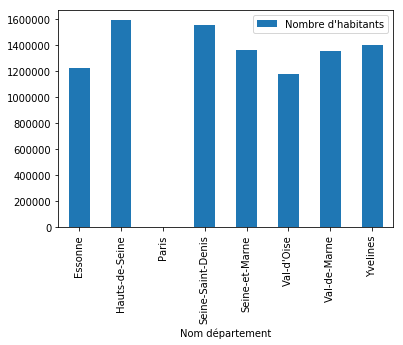

In [78]:
# Population per departments
population_by_department = pd.DataFrame(columns=['Nom département', 'Nombre d\'habitants'])
population_by_department['Nom département'] = sorted((localities["Nom département"][(localities["Nom région"] == selected_region.value)]).drop_duplicates())

for index, row in population_by_department.iterrows():
    population_by_department.loc[index, 'Nombre d\'habitants'] = localities.loc[localities['Nom département'] == population_by_department.loc[index, 'Nom département'], 'Nombre d\'habitants'].sum(axis=0)
population_by_department = population_by_department.set_index('Nom département')

#ax1 = plt.subplot(121, aspect='equal')
#population_by_department.plot(kind='pie', y='Nombre d\'habitants', ax=ax1, figsize=(15,15), labels=population_by_department.index, legend=False, fontsize=8, autopct='%1.0f%%', pctdistance=0.8, labeldistance=1.2)
population_by_department.plot(kind='bar')
total_population_by_selected_region = population_by_department['Nombre d\'habitants'].sum()
print("Total population of the selected region: " + "{:,}".format(total_population_by_selected_region))

# Indicators  in the selected department
- Statistics about 
- City with house rentals
- ...